# Deep Learning Indonesia.AI
Pertemuan - 6 Process Forward & Backward Propogation

# Import Library

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pprint

from random import random, seed; seed(90)

plt.style.use('ggplot')

# Init Neural Network

In [2]:
def init_neural_network(num_inputs, num_hidden, num_outputs):
    
    network = list()
    
    # include additional weight for the bias
    hidden_layer = [{'weights': [random() for _ in range (num_inputs + 1)]} for _ in range(num_hidden)] # include bias
    network.append(hidden_layer)
    
    output_layer = [{'weights': [random() for _ in range(num_hidden + 1)]} for _ in range(num_outputs)]
    network.append(output_layer)
    
    return network

In [3]:
network = init_neural_network(num_inputs=2, num_hidden=1, num_outputs=2)
print(f'Total hidden: {len(network[0])} neuron')
print(f'Total output: {len(network[1])} neurons')

Total hidden: 1 neuron
Total output: 2 neurons


In [6]:
# show hidden and output layers (total 3 neurons)
# we can see the hidden layer has 1 neuron with 2 input weights plus the bias and the output layer has 2 neurons, each with 1 weight plus the bias
for layer in network: 
    pprint.pprint(layer)

[{'weights': [0.20367044742105156, 0.09269342184833151, 0.6594800023332608]}]
[{'weights': [0.5861294218137865, 0.6344092107298325]},
 {'weights': [0.35484694544207973, 0.45126484018795465]}]


## Forward Propagate

### Neuron Activation

In [7]:
def activate(inputs, weights):
        
    activation = 0.0
    
    for i in range(len(weights)-1): # this performs like linear regression
        activation += weights[i] * inputs[i]
    
    bias = weights[-1] # get special weight bias that has no input to multiply with
    activation += bias
    
    return activation

### Neuron Transfer by Sigmoid

In [8]:
# the function that will be used to easily calculate the derivative (slope) on backpropagation later
# exp is the base of the natural logarithms Euler’s number
def transfer(activation):
    return 1.0 / (1.0 + math.exp(-activation))

### Forward Process

In [9]:
def forward_propagate(network, features):
    
    inputs = features
    for layer in network: # 2 layers
        
        new_inputs = []
        
        # each neuron has a set of weights
        for neuron in layer: # 1 neurons of hidden layer, and 2 neurons of output layer
            activation = activate(inputs, neuron['weights']) # total 3 neurons will be activated
            neuron['outputs'] = transfer(activation)
            new_inputs.append(neuron['outputs']) # the outputs from one layer become inputs to the neurons on the next layer
        inputs = new_inputs
    return inputs

In [10]:
features = [0.98, 0.01, None] # arbitrary number of features
outputs = forward_propagate(network, features)

In [11]:
# because the output layer has two neurons, we get a list of two numbers as output
print('Network outputs:', outputs)

Network outputs: [0.7400560278481565, 0.6683212567924518]


## Backward Propagate

### Transfer Derivative

In [12]:
# given an output value from a neuron, we need to calculate its slope to help direct the tunintg of weights
# below is the beautiful derivative of the sigmoid function
def transfer_derivative(outputs):
    return outputs * (1.0 - outputs)

### Error Backpropagtion

In [13]:
def backward_propagate_error(network, labels):
    
    # reversed the process to perform backpropagate
    for i in reversed(range(len(network))):
        
        # started at the output layer and working backward
        layer = network[i]
        errors = list()
        
        # calculate errors if the output layer
        if i == len(network)-1:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append((labels[j] - neuron['outputs']))
        
        # calculate errors if the hidden layer (uses delta)
        else:
            for j in range(len(layer)):
                
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
                
        # calculate delta based on errors calculated before
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['outputs'])

In [14]:
labels = [0, 1]
backward_propagate_error(network, labels)

In [15]:
for layer in network: pprint.pprint(layer) # include delta

[{'delta': -0.011983326768545521,
  'outputs': 0.7026614848405752,
  'weights': [0.20367044742105156, 0.09269342184833151, 0.6594800023332608]}]
[{'delta': -0.1423668748364181,
  'outputs': 0.7400560278481565,
  'weights': [0.5861294218137865, 0.6344092107298325]},
 {'delta': 0.07352254856186494,
  'outputs': 0.6683212567924518,
  'weights': [0.35484694544207973, 0.45126484018795465]}]


## Train Network

### Update Weights

In [16]:
def update_weights(network, features, learning_rate):
    
    for i in range(len(network)):
        
        inputs = features[:-1] # ignore the label or class
        
        # if hidden or output layer set outputs of previous layer into inputs
        if i != 0:
            inputs = [neuron['outputs'] for neuron in network[i - 1]]
            
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += learning_rate * neuron['delta'] * inputs[j] # update weights
            neuron['weights'][-1] += learning_rate * neuron['delta']

### Set Loss Function

In [17]:
def calculate_sum_squared_error(outputs, labels):
    
    error = sum([(labels[i] - outputs[i])**2 for i in range(len(labels))])
    return error

### Train Network

In [18]:
def train_network(network, data, num_outputs, learning_rate, num_epochs):
    
    total_loss = []
    print_every = 4
    
    for epoch in range(1, num_epochs+1):
        
        sum_error = 0.0
        
        for features in data:
            
            # forward propagation
            outputs = forward_propagate(network, features)
            labels = [0 for _ in range(num_outputs)]
            labels[features[-1]] = 1
            sum_error += calculate_sum_squared_error(outputs, labels)
            
            # backward propagation
            backward_propagate_error(network, labels)
            
            # optimize weights
            update_weights(network, features, learning_rate)
        
        if epoch % print_every == 0:
            print(f'Epoch: {epoch}, Learning rate: {learning_rate:.3f}, Loss: {sum_error:.3f}')
        
        total_loss.append(sum_error)
        
    # removes all delta and outputs calculations
    for layer in network: 
        for neuron in layer: del neuron['outputs']; del neuron['delta']
            
    return total_loss

## Run Network

In [19]:
def plot_network(loss):
    
    plt.plot(total_loss)
    plt.title('Total loss of training model')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.grid(True); plt.show()

In [20]:
# refers to http://archive.ics.uci.edu/ml/datasets/seeds for the original datasets
datasets = [[2.7810836, 2.550537003, 0], 
            [1.465489372, 2.362125076, 0], 
            [3.396561688, 4.400293529, 0], 
            [1.38807019, 1.850220317, 0], 
            [3.06407232, 3.005305973, 0], 
            [7.627531214, 2.759262235, 1], 
            [5.332441248, 2.088626775, 1], 
            [6.922596716, 1.77106367, 1], 
            [8.675418651, -0.242068655, 1], 
            [7.673756466, 3.508563011, 1]]

In [21]:
num_inputs = len(datasets[0]) - 1 # ignore the labels or class
num_outputs = len(set([features[-1] for features in datasets]))

In [22]:
network = init_neural_network(num_inputs=num_inputs, num_hidden=2, num_outputs=num_outputs)

Epoch: 4, Learning rate: 0.400, Loss: 5.408
Epoch: 8, Learning rate: 0.400, Loss: 4.859
Epoch: 12, Learning rate: 0.400, Loss: 4.073
Epoch: 16, Learning rate: 0.400, Loss: 3.064
Epoch: 20, Learning rate: 0.400, Loss: 2.242
Epoch: 24, Learning rate: 0.400, Loss: 1.667
Epoch: 28, Learning rate: 0.400, Loss: 1.277
Epoch: 32, Learning rate: 0.400, Loss: 1.011
Epoch: 36, Learning rate: 0.400, Loss: 0.822
Epoch: 40, Learning rate: 0.400, Loss: 0.684
Epoch: 44, Learning rate: 0.400, Loss: 0.579
Epoch: 48, Learning rate: 0.400, Loss: 0.496
Epoch: 52, Learning rate: 0.400, Loss: 0.429
Epoch: 56, Learning rate: 0.400, Loss: 0.372
Epoch: 60, Learning rate: 0.400, Loss: 0.323
Epoch: 64, Learning rate: 0.400, Loss: 0.281
Epoch: 68, Learning rate: 0.400, Loss: 0.246
Epoch: 72, Learning rate: 0.400, Loss: 0.217
Epoch: 76, Learning rate: 0.400, Loss: 0.192
Epoch: 80, Learning rate: 0.400, Loss: 0.172
Epoch: 84, Learning rate: 0.400, Loss: 0.155
Epoch: 88, Learning rate: 0.400, Loss: 0.141
Epoch: 92, L

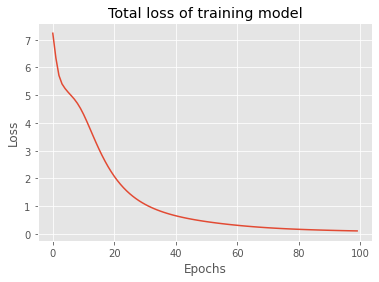

In [23]:
total_loss = train_network(network, datasets, num_outputs, learning_rate=0.4, num_epochs=100)
plot_network(total_loss)

## Predict

In [24]:
def predict(network, features):
    outputs = forward_propagate(network, features)
    return outputs.index(max(outputs))

In [25]:
def calculate_accuracy(predictions, labels):
    
    score = 0.0
    for pred, label in zip(predictions, labels):
        if pred == label:
            score += 1.
            
    accuracy = (score/ len(labels)) * 100.
    return accuracy

In [26]:
predictions = []; labels = []
for features in datasets:
    prediction = predict(network, features)
    
    predictions.append(prediction)
    labels.append(features[-1])
    
accuracy = calculate_accuracy(predictions, labels)
print(f'Model Accuracy: {accuracy}%')

Model Accuracy: 100.0%
